# DMQC Report: WMO 4901135

## Current status and metadata: 

- APEX float in Pacific Ocean
- Deployed in August 2010, inactive since September 2012
- Completed 83 cycles over 2.5 years
- Core files in D-mode, Oxygen in A-mode adjusted by Henry Bittig

In [13]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib.dates import datestr2num
import matplotlib.pyplot as plt
import seaborn as sns

from netCDF4 import Dataset

from pathlib import Path
import numpy as np
import pandas as pd
import bgcArgoDMQC as bgc

wmo = 4901135 # insert WMO number here
fig_path = Path('../../../figures/') / f'{wmo}' # where to save figures
fig_path.mkdir(exist_ok=True)
bgc.io.get_argo(wmo, local_path=bgc.io.Path.ARGO_PATH) # download the data to ensure you have up to date files
flt = bgc.sprof(wmo)
flt.clean()
gains = flt.calc_gains(ref='WOA') # calculate gain, can change to ref='NCEP' if in-air data is available
print(np.nanmean(gains))

# check what/if anything is done already
nc = Dataset(flt.__Sprof__)
print(bgc.io.read_ncstr(nc['SCIENTIFIC_CALIB_COMMENT'][:][50,-1,3,:]))
print(nc['DOXY_ADJUSTED'][:][-1,:]/nc['DOXY'][:][-1,:])
nc.close()

\Users\GordonC\Documents\data\Argo\dac\meds\4901135\4901135_Rtraj.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4901135\4901135_Sprof.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4901135\4901135_meta.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4901135\4901135_prof.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4901135\4901135_tech.nc
Extracting WOA data for Jan
Extracting WOA data for Feb
Extracting WOA data for Mar
Extracting WOA data for Apr
Extracting WOA data for May
Extracting WOA data for Jun
Extracting WOA data for Jul
Extracting WOA data for Aug
Extracting WOA data for Sep
Extracting WOA data for Oct
Extracting WOA data for Nov
Extracting WOA data for Dec

Calculating gains using WOA surface data and float O2 percent saturation...
1.0898499259402512
by Henry Bittig; ORCID 0000-0002-8621-3095; after Bittig et al. (2018) eq. 21 slope on PPOX_DOXY; Using in-air obs; No time response correction done; error gives 1 sigma
[1.0804237127304077 1.0804235935211182 1.080423712730407

## DOXY Audit Status

- If the float has any profiles present in the DOXY audit, which are they are why?
- Likely will usually be left empty/deleted

In [2]:
audit_file = list(Path('../../../audit/').glob('DOXY_WOA*'))[-1]
df = pd.read_csv(audit_file, sep='\t', header=25)
df = df.loc[df.WMO == wmo]
df['date'] = [datestr2num(t) for t in df['profile date']]
print(df['WOA G_raw'].mean())

nan


## Visual QC

- Visualize the float and reference surface saturations, as well as the profiles. 
- Observe if DOXY data is set to '3' as it should be or if it is '1' or '2'. 
- Try to note cycles or other identifying features of potentially problematic profiles.

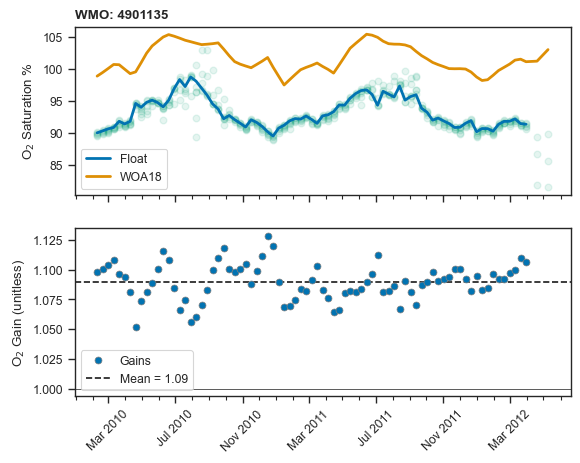

In [3]:
g = flt.plot('gain', ref='WOA')
g.axes[0].set_title(f'WMO: {wmo}', loc='left', fontweight='bold')
g.axes[0].plot(flt.df.SDN.loc[flt.df.PRES < 50], flt.df.O2Sat.loc[flt.df.PRES < 50], 'o', zorder=0, alpha=0.1)
g.fig.savefig(fig_path / 'gain_initial.png', bbox_inches='tight', dpi=250)

Figure 1: Top panel: Float oxygen percent saturation (blue line) compared to WOA percent saturation (orange line), with DOXY audit flagged cycle percent saturation (green stars, if applicable) and raw float percent saturation (orange circles). Bottom panel: calculated gains (blue dots) and flagged gains from DOXY audit (orange stars).

Notes: [notes on what this figure tells you here] 

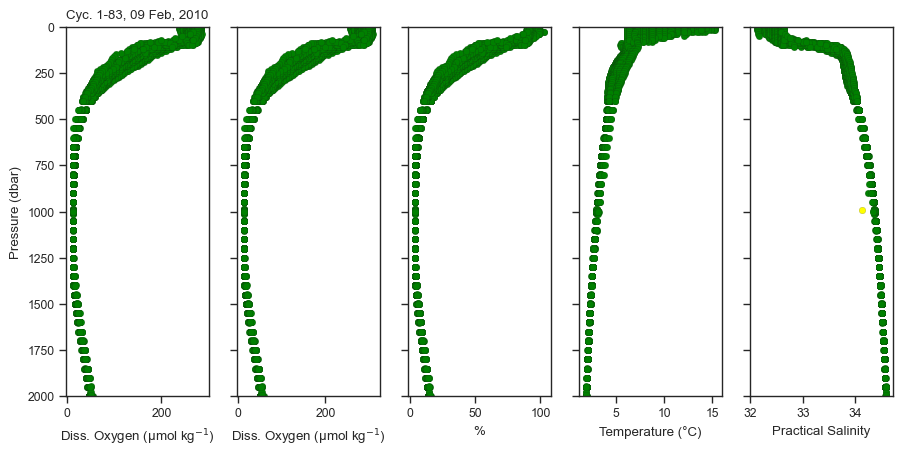

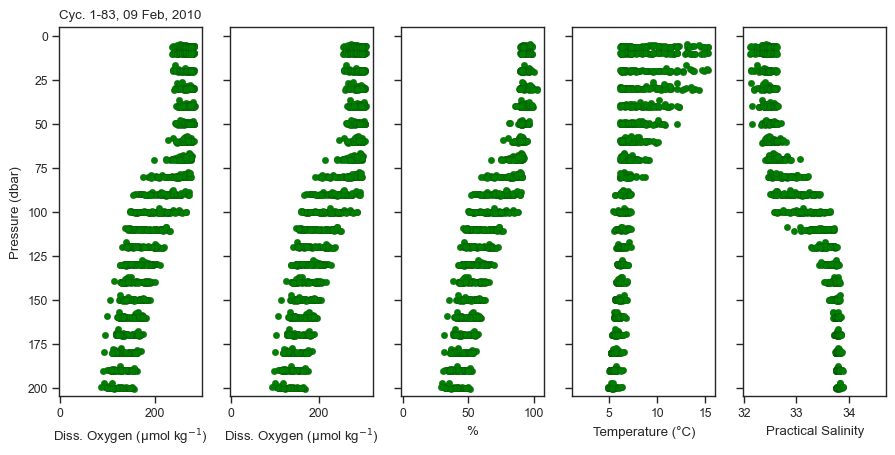

In [4]:
flt.reset()
g = flt.plot('qcprofiles', varlist=['DOXY', 'DOXY_ADJUSTED', 'O2Sat', 'TEMP', 'PSAL'])
g.fig.savefig(fig_path / 'qcprofiles.png', bbox_inches='tight', dpi=250)
g = flt.plot('qcprofiles', varlist=['DOXY', 'DOXY_ADJUSTED', 'O2Sat', 'TEMP', 'PSAL'])
g.axes[0].set_ylim((205, -5))
g.fig.savefig(fig_path / 'qcprofiles_shallow.png', bbox_inches='tight', dpi=250)

Figures 2,3: Profiles coloured by QC flag (1-2, green, 3, yellow, 4, red) on difference depth scales.

Notes: [notes on what this figure tells you here] 

## Flag bad data, recalculate gain

- Using the plots above (and likely some more specific plots, made on a case-by-case basis), flag bad DOXY data as 4. 
- After flagging bad data, re-clean the data and re-calculate the gains.

In [5]:
flt.reset(hard=True)
bad_oxygen = []
flt.update_field('DOXY_QC', 4, where=bad_oxygen)
flt.clean()
new_gains = flt.calc_gains(ref='WOA')
G = np.nanmean(new_gains)
print(G)

flt.update_field('DOXY_ADJUSTED_QC', 4, where=bad_oxygen)
flt.update_field('DOXY_ADJUSTED_ERROR', bgc.calc_fixed_doxy_adjusted_error(flt.PSAL, flt.TEMP, flt.PRES))


Updating DOXY_QC on 0 levels

Calculating gains using WOA surface data and float O2 percent saturation...
1.0898499259402512
Updating DOXY_ADJUSTED_QC on 0 levels
Updating DOXY_ADJUSTED_ERROR on all levels


Figure x: Repeated gain plot with bad data removed.

## Update Fields and Export

- DOXY should be 3 by default, but many old floats have 1 or 0. Though it will be redundant in some cases, make sure DOXY_QC is not good.
- Apply the gain to calculate DOXY_ADJUSTED. 
- Fill in DOXY_ADJUSTED_ERROR with an appropriate fixed value.
- Fill in DOXY_ADJUSTED_QC. 
- Make sure DOXY_ADJUSTED and DOXY_ADJUSTED_ERROR are `FillValue` wherever DOXY_ADJUSTED_QC is bad.
- Export the D-mode files. During export, HISTORY parameters will be filled as well as SCIENTIFIC_CALIB parameters using some default structures and user info set by calling `bgc.configure.configure()`.

Updating DOXY_QC on 0 levels
Updating DOXY_ADJUSTED_QC on 0 levels
Updating DOXY_ADJUSTED_QC on 0 levels
Updating DOXY_ADJUSTED_QC on 0 levels
Updating DOXY_ADJUSTED on 857 levels
Updating DOXY_ADJUSTED_ERROR on 857 levels


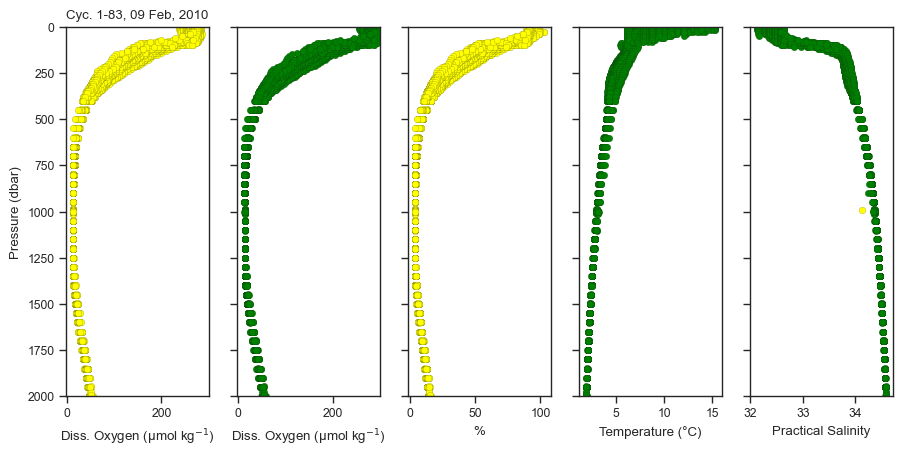

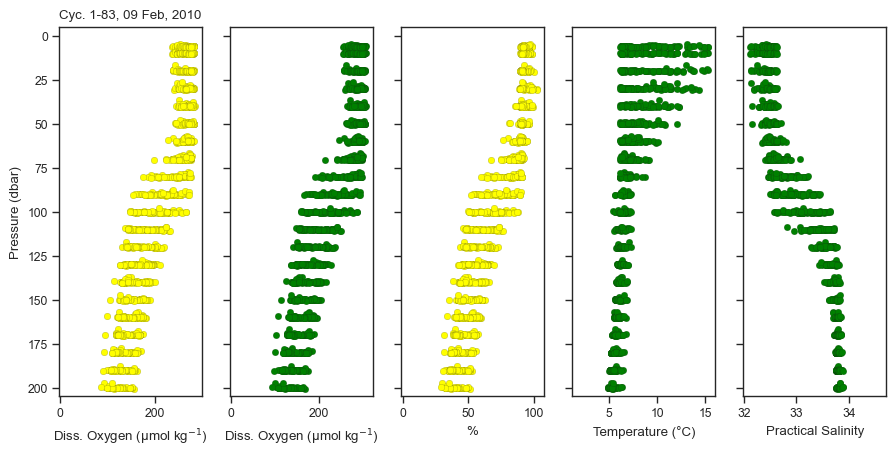

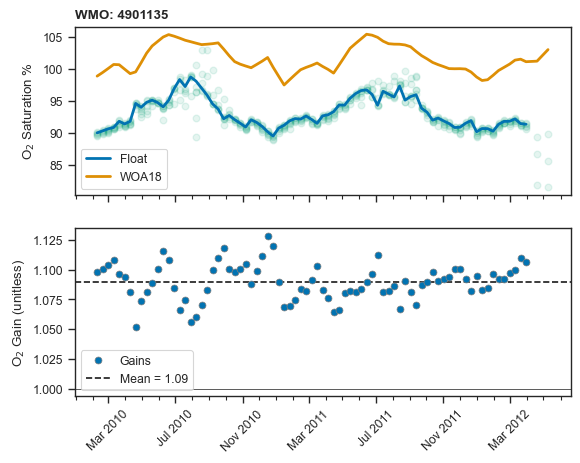

In [9]:
# make sure DOXY_QC is 3 instead of 0,1,2
flt.update_field('DOXY_QC', 3, where=flt.DOXY_QC.isin([0, 1, 2]))
# fill in DOXY_ADJUSTED_QC appropriately
flt.update_field('DOXY_ADJUSTED_QC', 4, where=flt.TEMP_ADJUSTED_QC == 4)
flt.update_field('DOXY_ADJUSTED_QC', 3, where=flt.PSAL_ADJUSTED_QC == 4)
# make sure the data is FillValues where adjusted values are still bad
flt.update_field('DOXY_ADJUSTED_QC', 4, where=flt.DOXY_ADJUSTED.isna())
flt.set_fillvalue('DOXY_ADJUSTED', where=flt.DOXY_ADJUSTED_QC == 4)
flt.set_fillvalue('DOXY_ADJUSTED_ERROR', where=flt.DOXY_ADJUSTED_QC == 4)

flt.reset()
g = flt.plot('qcprofiles', varlist=['DOXY', 'DOXY_ADJUSTED', 'O2Sat', 'TEMP', 'PSAL'])
g.axes[1].set_xlim(g.axes[0].get_xlim())
g.fig.savefig(fig_path / 'qcprofiles_postqc.png', bbox_inches='tight', dpi=250)
g = flt.plot('qcprofiles', varlist=['DOXY', 'DOXY_ADJUSTED', 'O2Sat', 'TEMP', 'PSAL'])
g.axes[0].set_ylim((205, -5))
g.fig.savefig(fig_path / 'qcprofiles_shallow_postqc.png', bbox_inches='tight', dpi=250)

flt.clean()
g = flt.plot('gain', ref='WOA')
g.axes[0].set_title(f'WMO: {wmo}', loc='left', fontweight='bold')
g.axes[0].plot(flt.df.SDN.loc[flt.df.PRES < 50], flt.df.O2Sat.loc[flt.df.PRES < 50], 'o', zorder=0, alpha=0.1)
g.fig.savefig(fig_path / 'gain_final.png', bbox_inches='tight', dpi=250)

48      13.071911
49      13.145025
50      13.213699
51      13.291340
52      13.348043
          ...    
5736    13.062537
5806    12.932213
5807    12.960637
5808    13.130085
5809    13.141414
Name: DOXY, Length: 272, dtype: float32


(12.0, 17.5)

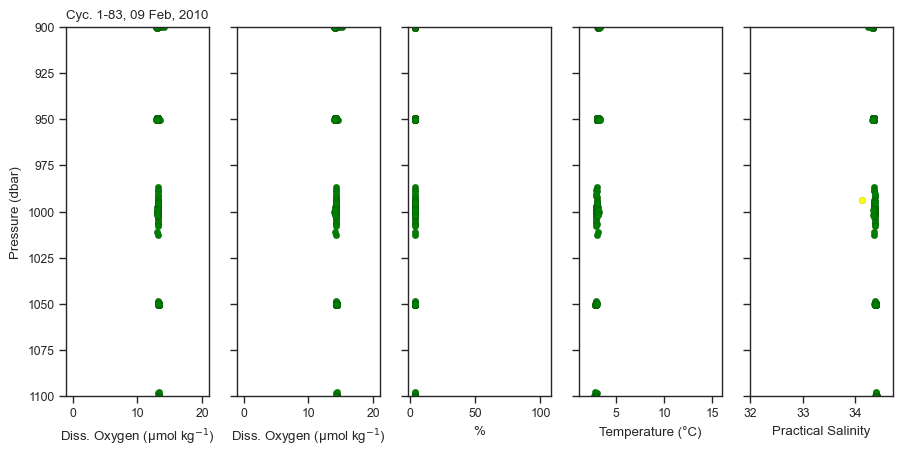

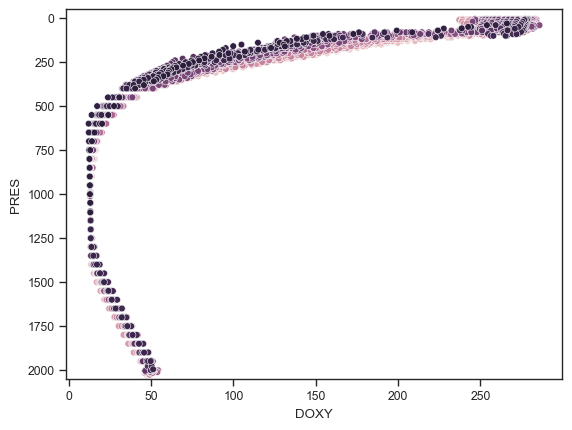

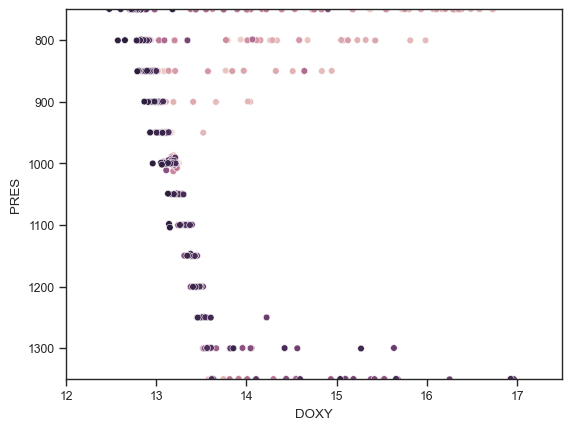

In [29]:
g = flt.plot('qcprofiles', varlist=['DOXY', 'DOXY_ADJUSTED', 'O2Sat', 'TEMP', 'PSAL'])
g.axes[0].set_ylim((1100, 900))
g.axes[0].set_xlim((-1, 21))
g.axes[1].set_xlim((-1, 21))
g.fig.savefig(fig_path / 'qcprofiles_1000m_postqc.png', bbox_inches='tight', dpi=250)

print(flt.df.loc[(flt.df.PRES > 900) & (flt.df.PRES < 1100), 'DOXY'])

fig, ax = plt.subplots()
sns.scatterplot(data=flt.df, x='DOXY', y='PRES', hue='CYCLE', ax=ax, legend=False)
ax.set_ylim((2050, -50))

fig, ax = plt.subplots()
sns.scatterplot(data=flt.df, x='DOXY', y='PRES', hue='CYCLE', ax=ax, legend=False)
ax.set_ylim((1350, 750))
ax.set_xlim((12, 17.5))



In [7]:
# export the files
comment = 'by Henry Bittig; ORCID 0000-0002-8621-3095; after Bittig et al. (2018) eq. 23 T-dependent slope on PPOX_DOXY with linear time trend in slope; Using in-air obs; No time response correction done; error gives 1 sigma'
comment += f"; Visual QC by Christopher Gordon (DFO, ORCID {bgc.config['orcid']})"
comment = comment.replace('No time response correction done;', '')
flt.export_files(data_mode='D', comment=comment, coeff='previous', equation='previous')

Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4901135/profiles/BD4901135_001.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4901135/profiles/BD4901135_002.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4901135/profiles/BD4901135_003.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4901135/profiles/BD4901135_004.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4901135/profiles/BD4901135_005.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4901135/profiles/BD4901135_006.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4901135/profiles/BD4901135_007.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4901135/profiles/BD4901135_008.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4901135/profiles/BD4901135_009.nc...done
Working on

In [8]:
# from pathlib import Path
# import pandas as pd
# from netCDF4 import Dataset
# import copy

# wmo = 4900874
# loc = Path(f'/Users/GordonC/Documents/data/Argo/dac/meds/D/{wmo}/profiles/')
# files = pd.read_csv(Path(f'../../../checker/summary/{wmo}/files.txt'))
# varname = 'DOXY'
# for fn in files.files:
#     print(fn)
#     nc = Dataset(loc / fn, 'r+')
#     print(nc['DOXY'][:])
#     flags = copy.deepcopy(nc[varname+'_QC'][:])
#     flags[nc[varname][:].mask] = b'9'
#     nc[varname+'_QC'][:] = flags
#     if varname == 'DOXY':
#         flags = copy.deepcopy(nc[varname+'_ADJUSTED_QC'][:])
#         flags[nc[varname][:].mask] = b'9'
#         nc[varname+'_ADJUSTED_QC'][:] = flags
#     profile = copy.deepcopy(nc['PROFILE_DOXY_QC'][:])
#     profile[0] = b'A'
#     nc['PROFILE_DOXY_QC'][:] = profile
#     nc.close()